In [2]:
from pandas import read_csv,DataFrame,concat
from sklearn.preprocessing import MultiLabelBinarizer,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from pyspark import SparkContext
from pyspark.sql import SQLContext
#sqlc = SQLContext()

In [4]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [3]:
mlb = MultiLabelBinarizer(sparse_output=True)

In [3]:
data = read_csv('extra_storage/project/lemmatized_comments.csv')

In [ ]:
!pip install emoji

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  Using cached https://files.pythonhosted.org/packages/40/8d/521be7f0091fe0f2ae690cc044faf43e3445e0ff33c574eae752dd7e39fa/emoji-0.5.4.tar.gz

In [47]:
#%%
import string
import emoji
from unicodedata import name
from collections import defaultdict
from textblob import TextBlob
from collections import Counter
from pandas import Series

#%%
def remove_emoji(comment, replace_with_text=False):
    '''
    Helper function to remove emoji from a string.

    Parameters:
    -----------
    comment:            str:    String to be cleaned
    replace_with_text:  bool:   Whether or not the emoji will be 
                                    replaced or removed
    Returns:
    --------
    str:    cleaned string
    '''
    if replace_with_text:
        return replace_emoji(comment)
    else:
        return comment.encode('ascii','ignore').decode('ascii')

def count_words(comment):
    '''
    Helper function to count the number of words in a string.

    Parameters:
    -----------
    comment:       str: String whose words will be counted

    Returns:
    --------
    int:    number of words in string
    '''
    return len(comment.split())

def get_grams(comment,n=2,keep_emoji_words=False):
    '''
    Returns n-grams for a sentence, optionally cleaning the string
    in the process.

    Parameters:
    -----------
    comment:            str:    sentence for which n-grams will be 
                                    made
    n:                  int:    number of tokens to include in n-gram
    keep_emoji_words:   bool:   whether emoji will be removed or 
                                    substituted with text 
                                    descriptions
    Returns:
    --------
    list:   list of n-grams
    '''
    blob = TextBlob(clean_text(comment, keep_emoji_words=\
                                        keep_emoji_words))
    return list([' '.join(wordlist) for wordlist in blob.ngrams(n)])
# %%
def clean_text(comment, keep_periods=True,\
                        keep_emoji_words=False):
    '''
    Removes all punctuation (and, optionally, emoji/non-ascii 
    characters) from a string.

    Parameters:
    -----------
    comment:            str:    the string whose punctuation/emoji 
                                    will be removed
    keep_periods:       bool:   whether or not periods will also be 
                                    removed
    keep_emoji_words:   bool:   whether emoji will be removed or 
                                    replaced with string descriptions
    
    Returns:
    --------
    str:    cleaned text
    '''
    translation_dic = {key:None for key in string.punctuation}
    if keep_periods:
        del translation_dic['.']
        tr_tab = str.maketrans(translation_dic)
    else:
        tr_tab = str.maketrans(translation_dic)
    return remove_emoji(comment,keep_emoji_words).translate(tr_tab)

def lemmatize(comment):
    '''
    Returns lemmatized version of reddit comment.

    Parameters:
    -----------
    comment:        str:    comment to lemmatize

    Returns:
    --------
    return_list:    str:  '''
    pass
def count_emoji(comment):
    '''
    Function that counts number of emoji in a string.

    Parameters:
    -----------
    comment:    str:    String from which number of emoji will be 
                            counted and returned
    Returns:
    --------
    int:    number of emoji present in string
    '''
    return sum([
        1 for character in comment 
            if character in emoji.UNICODE_EMOJI.keys()
    ])
def replace_emoji(comment):
    '''
    Function to replace emoji in a string.

    Parameters:
    -----------
    comment:    str:    String from which emoji will be replaced

    Returns:
    --------
    str:    Cleaned string where emoji have been repalced with ascii
                characters describing the image
    '''
    return ''.join([
        '_'.join(name(character).split())+' ' if character in
        emoji.UNICODE_EMOJI else character for character
        in comment
    ])

def stopwords_list(series,fraction = 0.2):
    '''
    Takes in a pandas.core.Series object, iterates over it, creating
    a list of words, then finds the most frequently used words in the
    corpus.
    
    Parameters:
    -----------
    series:     pd.core.Series: Series whose words will be counted
    fraction:   float: fraction of words to throw out

    Returns:
    list:   list of (fraction) most-frequently used words
    '''
    out = []
    for elements in series:
        cleaned = clean_text(elements,False,False)
        num_words = count_words(cleaned)
        if num_words > 1:
            out.extend(cleaned.split())
        elif num_words == 1:
            out.append(cleaned)
    ctr = [(word,count) for word,count in Counter(out).items()]
    ctr.sort(key=lambda x:x[1])
    ctr = ctr[::-1]
    if not fraction:
        return ctr
    else:
        cutoff_index = int(fraction*len(ctr))
        stopwords = [word for word,number in ctr]
        return stopwords[:cutoff_index]

def series_grams(series,n=2):
    '''
    Function that returns a pandas.core.Series containing n-grams for
    each row in the series that is passed to it.

    Parameters:
    -----------
    series: pd.core.series.Series: Series containing comments out of 
                                which n-grams are to be made
    n:      int:            integer number of tokens to includ in 
                                each n-gram
    
    Returns:
    --------
    pd.core.series.Series
    '''
    out = []
    for elements in series:        
        out.append(get_ngrams(elements.lower(),n))
    return Series(out)


# %%
def all_ngrams(series):
    '''
    Takes pandas.core.Series as argument, iterates over it, and 
    returns a set of all n-grams present in the series.

    Parameters:
    -----------
    series: pd.core.series.Series: series containing lists of ngrams

    Returns:
    --------
    out:    set:            set of all n-grams present in series
    '''

    out = set()
    for elements in series:
        for grams in elements:
            out.add(grams)
    return out

def make_dummies(df, col_name):
    '''
    Makes dummy columns from df column containing list of n-grams.

    Parameters:
    -----------
    df:         pd.core.frame.DataFrame:
    col_name:   str:    name of column from which dummies will be made

    Returns:
    pandas.core.frame.DataFrame
    '''

    gram_set = all_ngrams(df[col_name])
    for grams in gram_set:
        df[grams] = Series([0]*df.shape[0])
    for idx, row in df.iterrows():
        for grms in row[col_name]:
            df.loc[idx,grms] = 1
    del df[col_name]
    return df

def kill_stopwords(comment):
    return ' '.join([word for word in clean_text(comment).split() if word not in new_throw])

def get_ngrams(comment,n=2):
    return [' '.join(w) for s in TextBlob(comment).sentences for w in s.ngrams(n)]

In [48]:
data['2-gram'] = series_grams(data['reduced_sw'])

In [50]:
data.to_csv('reduced_2_gram.csv',index=False)

In [58]:
authors = [(person,count) for person,count in ctr.items()]
authors.sort(key=lambda x:x[1])
ppl = [author for author,count in authors[::-1]]

In [67]:
ppl = set([author for author,count in authors[::-1][1:] if count > 1900])

In [68]:
mask = data['author'].isin(ppl)
subset = data[mask]

MemoryError: Unable to allocate array with shape (77477, 363491) and data type int64

In [40]:
data['reduced_sw'] = data['lemma'].map(kill_stopwords)

In [41]:
data['reduced_sw']

0         Im guess buy Steam GOG Origin Uplay Whats Wind...
1                Bitcoins flaw inflation investment invest.
2                               That retard. So many wrong.
3                            The Bitcoin doom deflationary.
4                                      Well caught so work.
                                ...                        
799056                                   Huh pretty runner.
799057                                           Such game.
799058        It Ive bowling ground I guess probably thing.
799059                                        Id NZ I well.
799060                                                 Yes.
Name: reduced_sw, Length: 799061, dtype: object

In [33]:
data['reduced_count'] = data['reduced_sw'].map(list).map(clean_text).map(count_words)

AttributeError: 'set' object has no attribute 'encode'

In [30]:
for i,comment in enumerate(data['reduced_sw']):
    print(comment)
    print('+--------------------------------------------------+')    
    print('+--------------------------------------------------+')    
    print('+--------------------------------------------------+')
    if i > 5:
        break

{'origin', 'store.', 'buy', 'whats', 'guess'}
+--------------------------------------------------+
+--------------------------------------------------+
+--------------------------------------------------+
{'inflation', 'invest.', 'investment', 'flaw', 'bitcoins'}
+--------------------------------------------------+
+--------------------------------------------------+
+--------------------------------------------------+
{'retard.', 'many', 'so', 'wrong.'}
+--------------------------------------------------+
+--------------------------------------------------+
+--------------------------------------------------+
{'deflationary.', 'doom'}
+--------------------------------------------------+
+--------------------------------------------------+
+--------------------------------------------------+
{'work.', 'so', 'caught'}
+--------------------------------------------------+
+--------------------------------------------------+
+--------------------------------------------------+
{'tz.', 'pri

In [9]:
sw_list = stopwords_list(data['lemma'],None)

In [26]:
new_throw = set()
for w in throwout_words:
    if isinstance(w,str):
        new_throw.add(w.lower())
    else:
        new_throw.add(w[0].lower())

In [24]:
throwout_words

{'especiall',
 'borja',
 'Spys',
 'sirection',
 'YouhttpsiimgurcomPKeLzVQpng',
 'downthread',
 'Atlantichttpwwwtheatlanticcomtechnologyarchive201202imbeingfollowedhowgoogleand104othercompaniesaretrackingmeontheweb253758',
 'Emerys',
 'propagandaey',
 'Communisms',
 'LNB',
 'IDDMhttpsinvisiversewonderhowtocomnewsrootcausetype1diabetescouldbecommonchildhoodviralinfection0175880',
 'Cornflakes',
 'antigunantimedia',
 'sorrys',
 'relgion',
 'ghosthttpiimgurcomn2OqGpng',
 'Baldness',
 'Abaya',
 'sohttpiimgurcom2B9lSPrjpg',
 'Mariam',
 'Qwop',
 'hada',
 'httpiimgurcomOUPR92bljpg',
 'hangwoman',
 'Remi',
 'teoll',
 'Adjusted',
 'ROD',
 '0x67C2',
 'Hsus',
 'udilligafbazinga',
 'Frderungsbudget',
 'invents',
 'Teleported',
 'httpstimecom2822290tiananmensquaremassacrefactstime',
 'censorthrottle',
 'NSFWyou',
 'prevalemt',
 '20032018',
 'Ubis',
 'feeeeeeeeemales',
 'rcornouija',
 'peoplepeople',
 'Godzirra',
 'gulliable',
 'terrrist',
 'loweredhttpsenwikipediaorgwikiCSSShenandoahThelastloweringo

In [6]:
def lower(comment):
    return comment.lower()

g2 = series_grams(data['lemma'].map(lower).map(clean_text))

In [8]:
g2

0         [im guess, guess you, you buy, buy game, game ...
1         [bitcoins fatal, fatal flaw, flaw be, be there...
2         [that be, be really, really freak, freak retar...
3         [the technology, technology be, be great, grea...
4         [well these, these guy, guy do, do get, get ca...
                                ...                        
799056    [huh no, no wonder, wonder he, he such, such a...
799057                        [such a, a great, great game]
799058    [it just, just occur, occur to, to me, me ive,...
799059    [id say, say nz, nz but, but i, i dont, dont d...
799060                                                   []
Length: 799061, dtype: object

In [152]:
please_work[please_work['slurred'] == 1]

,author,body,sub_id,comment_id,subreddit,2_gram,3_gram,4_gram,2__gram,lemma,lowercase,count,slurred
6216,CouchPotatoFamine,"Truly, that is a faggot of epic proportions.",24k1eq,ch7vf3d,funny,"['truly that', 'that is', 'is a', 'a faggot', ...","['truly that is', 'that is a', 'is a faggot', ...","['truly that is a', 'that is a faggot', 'is a ...","[truly that, that is, is a, a faggot, faggot o...",Truly that be a faggot of epic proportion.,truly that be a faggot of epic proportion.,8,1
6489,CouchPotatoFamine,Fag,2z9n20,cpheq1a,classiccars,[],[],[],[],Fag.,fag.,1,1
10956,omnipedia,So you prefer lip service from a fag hater ove...,4mifnp,d3wqy50,lolgrindr,"['so you', 'you prefer', 'prefer lip', 'lip se...","['so you prefer', 'you prefer lip', 'prefer li...","['so you prefer lip', 'you prefer lip service'...","[so you, you prefer, prefer lip, lip service, ...",So you prefer lip service from a fag hater ove...,so you prefer lip service from a fag hater ove...,24,1
11296,omnipedia,"If I was full of shit, you could muster someth...",5phool,dcrsos5,pinkfloyd,"['if i', 'i was', 'was full', 'full of', 'of s...","['if i was', 'i was full', 'was full of', 'ful...","['if i was full', 'i was full of', 'was full o...","[if i, i was, was full, full of, of shit, shit...",If I be full of shit you could muster somethin...,if i be full of shit you could muster somethin...,67,1
11589,omnipedia,"If I was full of shit, you could muster someth...",5phool,dcrme4q,pinkfloyd,"['if i', 'i was', 'was full', 'full of', 'of s...","['if i was', 'i was full', 'was full of', 'ful...","['if i was full', 'i was full of', 'was full o...","[if i, i was, was full, full of, of shit, shit...",If I be full of shit you could muster somethin...,if i be full of shit you could muster somethin...,67,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
782029,chrispdx,BREAKING NEWS: OP NOT A FAGGOT. FILM AT 11,1go7rt,camhkxm,thick,"['breaking news', 'news op', 'op not', 'not a'...","['breaking news op', 'news op not', 'op not a'...","['breaking news op not', 'news op not a', 'op ...","[breaking news, news op, op not, not a, a fagg...",BREAKING NEWS OP NOT A FAGGOT. FILM AT 11.,breaking news op not a faggot. film at 11.,9,1
782227,chrispdx,"My father, .\nwho grew up in more racist times...",27nrbc,ci2sjt1,videos,"['my father', 'father who', 'who grew', 'grew ...","['my father who', 'father who grew', 'who grew...","['my father who grew', 'father who grew up', '...","[my father, father who, who grew, grew up, up ...",My father. who grow up in more racist time tol...,my father. who grow up in more racist time tol...,90,1
782296,chrispdx,The average Republican laughs in your face ove...,iqud1,c25wt7z,politics,"['the average', 'average republican', 'republi...","['the average republican', 'average republican...","['the average republican laughs', 'average rep...","[the average, average republican, republican l...",The average Republican laugh in your face over...,the average republican laugh in your face over...,62,1
782370,chrispdx,While I've often remarked on the Ivory Tower w...,11n1qd,c6nvl96,PoliticalDiscussion,"['while ive', 'ive often', 'often remarked', '...","['while ive often', 'ive often remarked', 'oft...","['while ive often remarked', 'ive often remark...","[while ive, ive often, often remarked, remarke...",While Ive often remark on the Ivory Tower we R...,while ive often remark on the ivory tower we r...,98,1


In [30]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /home/justin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [142]:
ct = [(author,count) for author,count in Counter(please_work['author'].values).items()]
ct.sort(key=lambda x:x[1])
a_set = set([author for author,count in ct[::-1][:50]])

In [144]:
please_work = please_work.loc[with_author['author'].isin(a_set)]

In [51]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {'J':wordnet.ADJ,'N':wordnet.NOUN,'V':wordnet.VERB,
               'R':wordnet.ADV}
    return tag_dict.get(tag,wordnet.NOUN)
def lemmatize_sentence(sentence):
    lemmatizer=WordNetLemmatizer()
    return ' '.join([
        lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in
        nltk.word_tokenize(sentence)
    ]) + '.'
def process_comment(comment):
    out = []
    for sentence in TextBlob(clean_text(comment)).sentences:
        out.append(' '.join(w.lemmatize(get_wordnet_pos(w)) for w in sentence.words))
    return '. '.join(out) + '.'

In [46]:
process_comment('These are a tests.  This is only a test.  This is not an actual emergency.')

'These be a test. This be only a test. This be not an actual emergency.'

In [76]:
mlb=MultiLabelBinarizer(sparse_output=True)
gram_2 = mlb.fit_transform(subset['2-gram'])

In [135]:
please_work['slurred2'] = please_work['lowercase'].map(slurred)

/home/justin/.local/opt/anaconda2/envs/galvanize/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


158

In [114]:
with_author = data[data['author'] != 'None']

In [57]:
def lower_case(text):
    return text.lower()

In [55]:
data.to_csv('extra_storage/lemmatized_comments.csv',index=False)

In [59]:
data['lowercase'].loc[0]

'im guess you buy game on steam gog origin uplay whats wrong with windows store.'

In [96]:
data['count'] = data['lowercase'].map(count_words)

In [101]:
from collections import Counter
ctr = [(word,count) for word,count in Counter(data['count'].values).items()]
ctr.sort(key=lambda x:x[1])
ctr[::-1]

[(1, 55706),
 (4, 36638),
 (5, 36273),
 (6, 35408),
 (3, 33566),
 (7, 33525),
 (8, 31138),
 (2, 29337),
 (9, 28684),
 (10, 26538),
 (11, 24446),
 (12, 22673),
 (13, 21247),
 (14, 19016),
 (15, 17778),
 (16, 16690),
 (17, 15328),
 (18, 14577),
 (19, 13515),
 (20, 12665),
 (21, 11795),
 (22, 10994),
 (23, 10283),
 (24, 9692),
 (25, 9073),
 (26, 8447),
 (27, 8165),
 (28, 7703),
 (29, 7181),
 (30, 6745),
 (31, 6304),
 (32, 6084),
 (33, 5782),
 (34, 5546),
 (35, 5351),
 (36, 4986),
 (37, 4808),
 (38, 4514),
 (39, 4485),
 (40, 4260),
 (41, 3983),
 (42, 3881),
 (43, 3628),
 (44, 3539),
 (45, 3343),
 (46, 3226),
 (47, 3067),
 (49, 2857),
 (48, 2847),
 (50, 2686),
 (51, 2667),
 (53, 2455),
 (52, 2418),
 (54, 2408),
 (55, 2382),
 (56, 2190),
 (58, 2090),
 (57, 2087),
 (61, 1966),
 (59, 1963),
 (60, 1890),
 (62, 1829),
 (63, 1751),
 (64, 1733),
 (65, 1583),
 (68, 1579),
 (66, 1544),
 (67, 1522),
 (69, 1457),
 (70, 1438),
 (71, 1352),
 (72, 1337),
 (73, 1301),
 (75, 1233),
 (74, 1194),
 (76, 1150)

In [109]:
longer = data[data['count'] > 15]

In [15]:
enc.fit_transform(data['2__gram'].str.join(' '))

<799061x259508 sparse matrix of type '<class 'numpy.int64'>'
	with 15825468 stored elements in Compressed Sparse Row format>

In [2]:
data = read_csv('../data_with_n_grams.csv')

In [97]:
data.set_index(keys='comment_id',inplace=True)

In [3]:
def evaluate(row):
    return eval(row)
data['2__gram'] = data['2_gram'].map(evaluate)
# data['3__gram'] = data['3_gram'].map(evaluate)
# data['4__gram'] = data['4_gram'].map(evaluate)

In [ ]:
dat_2=DataFrame(mlb.fit_transform(data['2__gram']),columns=mlb.classes_,index=data.index)

In [76]:
eval(data['2_gram'].loc[0])

['im guessing',
 'guessing you',
 'you buy',
 'buy games',
 'games on',
 'on steam',
 'steam gog',
 'gog origin',
 'origin uplay',
 'uplay whats',
 'whats wrong',
 'wrong with',
 'with windows',
 'windows store']

In [77]:
enc.fit(eval(data['2_gram'].values.reshape(-1,1)))

ValueError: source code string cannot contain null bytes

In [73]:
f = enc.transform(data['2_gram'].values.reshape(-1,1))
for rows in f:
    print(rows.todense())
    print(enc.inverse_transform(rows.todense()))
    break

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [62]:
x = 2
for _ in range(1,33,3):
#     x**=2
    print(_,x**_)
x

1 2
4 16
7 128
10 1024
13 8192
16 65536
19 524288
22 4194304
25 33554432
28 268435456
31 2147483648


2

In [74]:
#ndim = feature.shape[1]
from copy import deepcopy
def get_neuron_counts(n: int) -> list:
    out = []
    accumulator = 3
#    out.append(n)
    while accumulator < n:
        out.append(accumulator)
        accumulator **= 2
    out.append(n)
    sub = deepcopy(out[:-1])
    out = out[::-1]
    out.extend(sub[1:])
    out.append(n)
    #out.append(n)
    return out

In [89]:
get_neuron_counts(gram_2.shape[1])

[3491207, 6561, 81, 9, 3, 9, 81, 6561, 3491207]

In [75]:
def make_autoencoder(ngram):
    model = Sequential()
    for i,count in enumerate(get_neuron_counts(ngram.shape[1])):
        if i == 0:
            model.add(Dense(count, input_dim=count, activation='relu'))
        elif count == 3:
            model.add(Dense(count,activation='linear',name='bn'))
        elif count == ngram.shape[1] and i != 0:
            model.add(Dense(count,activation='sotfmax'))
    return model

In [91]:
subset.to_csv('subset_of_data.csv',index=False)

In [1]:
import pyspark as ps
spark = ps.sql.SparkSession\
        .builder\
        .master('local[4]')\
        .appName('capstone')\
        .getOrCreate()
sc = spark.sparkContext

In [90]:
mmake_autoencoder(vectorized)

ResourceExhaustedError: OOM when allocating tensor with shape[47865,47865] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:Add] name: dense_1/kernel/Initializer/random_uniform/

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation

In [44]:
def create_autoencoder(neuron_counts)
    model = Sequential([
        Dense(ndim,input_dim=ndim,activation='relu'),
       # Activation('relu'),
        Dense(256,activation='relu'),
       # Activation('relu'),
        Dense(16,activation='relu'),
      #  Activation('tanh'),
        Dense(4,activation='relu'),
      #  Activation('tanh'),
        Dense(2,activation='linear',name='bottleneck'),
      #  Activation('linear',name='bottleneck'),
        Dense(4,activation='relu'),
      #  Activation('tanh'),
        Dense(16,activation='relu'),
      #  Activation('relu'),
        Dense(256,activation='relu'),
       # Activation('relu'),
        Dense(ndim)    
    ])

In [45]:
model.compile(loss='mean_squared_error',optimizer='adam',verbose=1)

In [46]:
history=model.fit(feature.todense().astype(float),feature.todense().astype(float),batch_size=128,epochs=10)

Train on 500 samples
Epoch 1/10
500/500 [==============================] - 8s 16ms/sample - loss: 0.0020
Epoch 2/10
500/500 [==============================] - 0s 444us/sample - loss: 0.0020
Epoch 3/10
500/500 [==============================] - 0s 380us/sample - loss: 0.0020
Epoch 4/10
500/500 [==============================] - 0s 397us/sample - loss: 0.0020
Epoch 5/10
500/500 [==============================] - 0s 346us/sample - loss: 0.0020
Epoch 6/10
500/500 [==============================] - 0s 348us/sample - loss: 0.0020
Epoch 7/10
500/500 [==============================] - 0s 269us/sample - loss: 0.0020
Epoch 8/10
500/500 [==============================] - 0s 321us/sample - loss: 0.0020
Epoch 9/10
500/500 [==============================] - 0s 336us/sample - loss: 0.0020
Epoch 10/10
500/500 [==============================] - 0s 296us/sample - loss: 0.0020


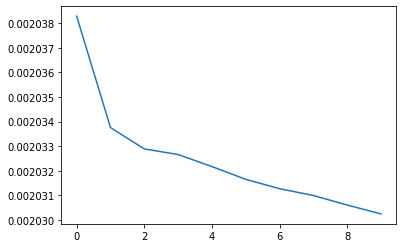

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 491)               241572    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               125952    
_________________________________________________________________
dense_11 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_15 (Dense)             (None, 16)               

In [51]:
model.layers[4][feature[0].todense().astype(float)]

TypeError: 'Dense' object is not subscriptable

In [52]:
layer_outputs=[feature.todense().astype(float)]
for layer in model.layers:
    layer_outputs.append( layer( layer_outputs[-1] ) )



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [53]:
for i, ll in enumerate( layer_outputs ):
    print( "layer {} -- shape {}".format(i+1, ll.shape) )

layer 1 -- shape (500, 491)
layer 2 -- shape (500, 491)
layer 3 -- shape (500, 256)
layer 4 -- shape (500, 16)
layer 5 -- shape (500, 4)
layer 6 -- shape (500, 2)
layer 7 -- shape (500, 4)
layer 8 -- shape (500, 16)
layer 9 -- shape (500, 256)
layer 10 -- shape (500, 491)


In [57]:
layer_outputs[5]

<tf.Tensor: id=2771, shape=(500, 2), dtype=float32, numpy=
array([[ 0.00628065, -0.00896744],
       [ 0.00628065, -0.00896744],
       [ 0.00851696, -0.00354056],
       [ 0.00164961, -0.01630626],
       [-0.00116533, -0.02076709],
       [ 0.00628065, -0.00896744],
       [ 0.00419633, -0.01071405],
       [ 0.00501441, -0.01097406],
       [ 0.00628065, -0.00896744],
       [ 0.00628065, -0.00896744],
       [ 0.00437182, -0.01199236],
       [ 0.00549238, -0.01021662],
       [ 0.00963753,  0.00445831],
       [ 0.00570249, -0.0083591 ],
       [ 0.00594804, -0.00949454],
       [-0.00058731, -0.01985111],
       [ 0.00550198, -0.0102014 ],
       [ 0.00046543, -0.01818283],
       [ 0.01364609,  0.00890641],
       [ 0.00645177, -0.00855218],
       [ 0.00585181, -0.00964703],
       [ 0.00628065, -0.00896744],
       [ 0.00628065, -0.00896744],
       [ 0.00839744,  0.00142766],
       [ 0.00391639, -0.01271409],
       [ 0.00628065, -0.00896744],
       [ 0.00364558, -0.0131432

In [71]:
#%%
import string
import emoji
from unicodedata import name
from collections import defaultdict
from textblob import TextBlob
from collections import Counter
from pandas import Series

#%%
def remove_emoji(comment, replace_with_text=False):
    '''
    Helper function to remove emoji from a string.

    Parameters:
    -----------
    comment:            str:    String to be cleaned
    replace_with_text:  bool:   Whether or not the emoji will be 
                                    replaced or removed
    Returns:
    --------
    str:    cleaned string
    '''
    if replace_with_text:
        return replace_emoji(comment)
    else:
        return comment.encode('ascii','ignore').decode('ascii')

def count_words(comment):
    '''
    Helper function to count the number of words in a string.

    Parameters:
    -----------
    comment:       str: String whose words will be counted

    Returns:
    --------
    int:    number of words in string
    '''
    return len(comment.split())

def get_grams(comment,n=2,keep_emoji_words=False):
    '''
    Returns n-grams for a sentence, optionally cleaning the string
    in the process.

    Parameters:
    -----------
    comment:            str:    sentence for which n-grams will be 
                                    made
    n:                  int:    number of tokens to include in n-gram
    keep_emoji_words:   bool:   whether emoji will be removed or 
                                    substituted with text 
                                    descriptions
    Returns:
    --------
    list:   list of n-grams
    '''
    blob = TextBlob(clean_text(comment, keep_emoji_words=\
                                        keep_emoji_words))
    return list([' '.join(wordlist) for wordlist in blob.ngrams(n)])
# %%
def clean_text(comment, keep_periods=True,\
                        keep_emoji_words=False):
    '''
    Removes all punctuation (and, optionally, emoji/non-ascii 
    characters) from a string.

    Parameters:
    -----------
    comment:            str:    the string whose punctuation/emoji 
                                    will be removed
    keep_periods:       bool:   whether or not periods will also be 
                                    removed
    keep_emoji_words:   bool:   whether emoji will be removed or 
                                    replaced with string descriptions
    
    Returns:
    --------
    str:    cleaned text
    '''
    translation_dic = {key:None for key in string.punctuation}
    if keep_periods:
        del translation_dic['.']
        tr_tab = str.maketrans(translation_dic)
    else:
        tr_tab = str.maketrans(translation_dic)
    return remove_emoji(comment,keep_emoji_words).translate(tr_tab)

def lemmatize(comment):
    '''
    Returns lemmatized version of reddit comment.

    Parameters:
    -----------
    comment:        str:    comment to lemmatize

    Returns:
    --------
    return_list:    str:  
    '''
    pass
def count_emoji(comment):
    '''
    Function that counts number of emoji in a string.

    Parameters:
    -----------
    comment:    str:    String from which number of emoji will be 
                            counted and returned
    Returns:
    --------
    int:    number of emoji present in string
    '''
    return sum([
        1 for character in comment 
            if character in emoji.UNICODE_EMOJI.keys()
    ])
def replace_emoji(comment):
    '''
    Function to replace emoji in a string.

    Parameters:
    -----------
    comment:    str:    String from which emoji will be replaced

    Returns:
    --------
    str:    Cleaned string where emoji have been repalced with ascii
                characters describing the image
    '''
    return ''.join([
        '_'.join(name(character).split())+' ' if character in
        emoji.UNICODE_EMOJI else character for character
        in comment
    ])

def stopwords_list(series,fraction = 0.2):
    '''
    Takes in a pandas.core.Series object, iterates over it, creating
    a list of words, then finds the most frequently used words in the
    corpus.
    
    Parameters:
    -----------
    series:     pd.core.Series: Series whose words will be counted
    fraction:   float: fraction of words to throw out

    Returns:
    list:   list of (fraction) most-frequently used words
    '''
    out = []
    for elements in series:
        cleaned = clean_text(elements,False,False)
        num_words = count_words(cleaned)
        if num_words > 1:
            out.extend(cleaned.split())
        elif num_words == 1:
            out.append(cleaned)
    ctr = [(word,count) for word,count in Counter(out).items()]
    ctr.sort(key=lambda x:x[1])
    ctr = ctr[::-1]
    if not fraction:
        return ctr
    else:
        cutoff_index = int(fraction*len(ctr))
        stopwords = [word for word,number in ctr]
        return stopwords[:cutoff_index]

def series_grams(series,n=2):
    '''
    Function that returns a pandas.core.Series containing n-grams for
    each row in the series that is passed to it.

    Parameters:
    -----------
    series: pd.core.series.Series: Series containing comments out of 
                                which n-grams are to be made
    n:      int:            integer number of tokens to includ in 
                                each n-gram
    
    Returns:
    --------
    pd.core.series.Series
    '''
    out = []
    for elements in series:
        out.append(get_grams(elements.lower(),n))
    return Series(out)


# %%
def all_ngrams(series):
    '''
    Takes pandas.core.Series as argument, iterates over it, and 
    returns a set of all n-grams present in the series.

    Parameters:
    -----------
    series: pd.core.series.Series: series containing lists of ngrams

    Returns:
    --------
    out:    set:            set of all n-grams present in series
    '''

    out = set()
    for elements in series:
        for grams in elements:
            out.add(grams)
    return out

def make_dummies(df, col_name):
    '''
    Makes dummy columns from df column containing list of n-grams.

    Parameters:
    -----------
    df:         pd.core.frame.DataFrame:
    col_name:   str:    name of column from which dummies will be made

    Returns:
    pandas.core.frame.DataFrame
    '''

    gram_set = all_ngrams(df[col_name])
    for grams in gram_set:
        df[grams] = Series([0]*df.shape[0])
    for idx, row in df.iterrows():
        for grms in row[col_name]:
            df.loc[idx,grms] = 1
    del df[col_name]
    return df

slurs = set([
    'ching chong','chink','christ-killer','christ killer','gook',
    'goy','half-breed','half breed', 'heeb','hebe','kike','jewboy',
    'jigaboo','jiggabo', 'jig', 'jigga', 'jigger', 'jungle bunny',
    'kyke','niglet','nig-nog', 'nig nog', 'nignog','nigger',
    'nigga', 'nigress','niggah', 'nigga','porch monkey','raghead',
    'rag head', 'sambo','shylock','slant-eye', 'slant eye','spic',
    'spick','spik','tar baby','tar-baby','tyrone','towel head', 
    'uncle tom','wetback','beaner','camel jockey','coon-ass','coon',
    'tnb','yard ape','welfare queen', 'unemployus', 'satchmo','sambo',
    'race traitor','race-traitor','mammy','pickaninny','sheboon',
    'furfag','chimpout','fag','faggot','queer','dyke','cocksucker'
])
def slurred(comment):
    '''
    Takes in a comment and returns either 1 (if slur is present) or 0
    (if no slur is present).

    Parameters:
    -----------

    comment:    str:    string to parse for comments.

    Returns:
    --------

    int: [0,1]
    '''
    comment_words = set(clean_text(comment,False,False).split())
    return int(len(comment_words.intersection(slurs)) > 0)

In [72]:
subset['slurred'] = subset['body'].map(slurred)

/home/justin/.local/opt/anaconda2/envs/galvanize/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
subset['count'] = subset['reduced_sw'].map(count_words)

/home/justin/.local/opt/anaconda2/envs/galvanize/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
subset['count']

6031      4
6032      7
6033      2
6034      3
6035      3
         ..
792266    3
792267    4
792268    2
792269    6
792270    4
Name: count, Length: 77477, dtype: int64

In [85]:
subset['2-gram']

6031              [what find, find elephant, elephant tail]
6032      [good hit, hit front, front page, page again, ...
6033                                        [just interest]
6034                                [so person, person rap]
6035                             [was full, full americans]
                                ...                        
792266                             [bapu extra, extra hoga]
792267                   [we respect, respect mr, mr beans]
792268                                          [bharat ki]
792269    [why how, how easy, easy settle, settle us, us...
792270                            [hero chutiyapa, dna hai]
Name: 2-gram, Length: 77477, dtype: object

In [86]:
cv = CountVectorizer()

In [89]:
vectorized = cv.fit_transform(subset['reduced_sw'])

In [96]:
ls

OSError: [Errno 12] Cannot allocate memory